<h1>Efficient Python Scripts Tutorial</h1>

<h2>Introduction</h2>

This tutorial, developped as part of the <a href="http://www.cse.chalmers.se/edu/year/2017/course/DAT300/">DAT300 / DIT615 Data-driven support for cyber-physical systems</a>, aims to give some simple and useful tips on how to improve the performance of your Python scripts. Python is now ubiquitous in many domains such as machine learning, embedded devices, scentific computing and networking. To follow the tutorial, you are expected to be at least "conversational" in Python that is to understand its syntax and having already programmed at least once in it. Let's note that the tutorial focuses on Python but many of the below tips are regardless applicable to other scripting languages.

<h3>About Python</h3>

Python is a multi-paradigm language that offers ease to program, ease to read source-code even when not knowing the language and comes with an intuitive networking library.

If you've never used it, it might be worth to follow a basic tutorial beforehand, for example check the <a href="https://www.python.org/about/gettingstarted/">getting started page</a>.

<h3>About the tutorial</h3>

You need a <a href="https://jupyter.readthedocs.io/en/latest/install.html">working jupyter notebook</a> to run the tutorial and if you are reading those lines it should be the case. The tutorial does not rely on any other packages.

The main purpose of the tutorial is to get a feeling of places where easy optimization is possible when writing your scripts. It was not meant as, but it can actually also be used as a quick reference for many python syntax as the small pieces of code deal with various Python aspects. At last the tutorial itself can also be a simple starting tool for using jupyter and is written for a complete beginner in jupyter.

The first exercises are more guided on purpose and the later ones are intended to be mainly explored by oneself. The main purpose of the tutorial, beyond giving you some useful tips and tricks to make your scripts more powerful, is to also provide a guide of habits when considering different implementation to choose from: **testing!**
    
**Disclaimer** We are still experiencing with such a tutorial and improving it over the years, so ideas to complement it and feedback are more than welcome!

### Some Jupyter shortcuts (for beginners to get started)

- a = add a new cell Above, b = add a new cell Below
- m = make a cell Markup, y = make a cell Code
- Ctrl + Enter to run a cell
- TAB to autocomplete your code
- Shift + TAB to display a *function definition* (quick acces to the documentation)
- toggle block comment: Ctrl + / (use numpad one on swedish keyboard)


# Part 0 -- Generate a fake database

The first step of the tutorial is to generate a fake database that will be used through the tutorial to get a feel about performance consequences of small decisions in your code. The database is generated in 10 different sizes where each is a simple csv file where each entry represents some abstract data made of a 60 characters identifier and 3 floats as the example below:

ID |Number1 |Number2 |Number3
:-:|:-:|:-:|:-:
9f6264b5864e4f3e15ef3fbe17b4c4bc90742a9093d5e55e12cdbdbc7191|0.8269301791|0.4302317251|0.9849347586
5f15e53e860c7e7bb6d653eed7443dc405748fb9dd8fdda09210b7c62a78|0.3773399908|0.9405536256|0.1265585766
38b8ce47beb818d0cbe5aefd9a6d617442a2641115148202d0c65427a5d2|0.7667240736|0.9778946135|0.9630533761
...|...|...|...

You can execute the following code without modifications (click on the section then CTRL + ENTER to execute it).

In [4]:
from random import random, getrandbits
from timeit import timeit
from matplotlib import pyplot as plt

"""
    Here are some utils that we will use in this tutorials
"""

# This generates a fake database with n rows
def generate_database(n):
    for _ in range(n):
        yield hex(getrandbits(60*4))[2:].zfill(60), random(), random(), random()

# This saves the database to a file without having had the object fully generated in memory
def stream2file(data, filename):
    with open(filename, "w") as outputfile:
        for record in data:
            print(record[0], *['{0:.10f}'.format(r) for r in record[1:]], sep=',', file=outputfile)

# This does the opposite, ie this is a generator for a saved database
def file2stream(filename):
    with open(filename, "r") as inputfile:
        for line in inputfile.readlines():
            record = line.split(',')
            yield record[0], *[float(x) for x in record[1:]]

# Macro to generate a set of database of different sizes
def generate_all_databases(max_size_in_bytes=100_000_000, nb_files=10):
    for i in range(1,nb_files+1):
        n = i*max_size_in_bytes//(100*nb_files)
        stream2file(generate_database(n), f"data{n}.csv")

# Macro to plot several lines sharing the same X axis
def plotNlines(X, lines):
    for name, points in lines:
        plt.plot(X, points, marker='o', label=name)
    plt.legend()
    plt.show()
    
# Default parameters for the experiments
M, N = 100_000_000, 10
M1 = M//(100*N)
sizes = [M1*(i+1) for i in range(2*N)]

# Generates a sequence of 'iterations' sizes from 'minsize' up to 'iterations*minsize'
def test_sizes(minsize=M1, iterations=N):
    for x in range(iterations):
        yield minsize*(x+1)

"""
    Here is a simple compare function that compare several implementation 
    by measuring the execution time for different size of input
"""
    
def compare(*args, iterations=N, minsize=M1, repetition=1):
    X = []
    Y = [(args[i][0],[]) for i in range(len(args))]
    for n in test_sizes(minsize, iterations):
        X.append(n)
        for i in range(len(args)):
            Y[i][1].append(timeit(args[i][1](n), number=repetition))
    
    plotNlines(X, Y)
    
"""
    This is a shortcut to generate a sequence of random numbers of size n
"""
generator = lambda n : (random() for _ in range(n))

"""
    This is a shortcut to create 20 lists of increasing size (from 100000 elements to 2000000)
    And stores the lists in a dicttionary so that lists[n] is a list of size n
"""
lists = dict(zip( (n for n in sizes), (list(generator(n)) for n in sizes) ))

Now check how much space you have free on your hard-drive and update the following line in consequence if needed. By default 10 files (nb_files) are created with increasing size from 10 MB to 100 MiB, for example use `generate_all_databases(1000000)` to generate files only up to 1 MiB of data and `generate_all_databases(1000000000)` for generating files up to 1 GB of data. Count ~20seconds for 100 MB max.

Execute the following (be default about 500 MiB of disk space is required):

In [5]:
generate_all_databases(M, N)

### Example of using the "compare" function

In the tutorial, you will be asked to compare different implementation. You can use for that the compare utility function written above.  

The function typically takes as argument:  
- pairs of the form ("name of the function for legend plot", *func_n*) where *func_n* is a function taking a parameter *n* and returning a function that we want to measure time for input n
- minsize [optional] controls the size of the first iteration. By default this is "M1" (execute the following line to see the value set for the first iteration)

In [3]:
M1

100000

- iterations [optional] controls how far will the test go. By default, 10 iterations are run with *n* taking the following values:

In [4]:
minsize, iterations = M1, 10
#[M1*(x+1) for x in range(iterations)]
sizes

[100000,
 200000,
 300000,
 400000,
 500000,
 600000,
 700000,
 800000,
 900000,
 1000000,
 1100000,
 1200000,
 1300000,
 1400000,
 1500000,
 1600000,
 1700000,
 1800000,
 1900000,
 2000000]

- repetition [optional] how many times "func_n(n)()" will be called to calculate how long it takes (timeit library)

Here is a minimalist example how to use it, comparing the function that calculates 2n with the one that calculates 2^n:

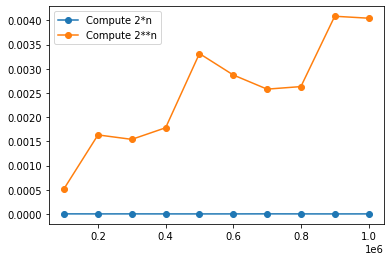

In [5]:
compare( ("Compute 2*n", lambda n: lambda: 2*n),
         ("Compute 2**n", lambda n: lambda: 2**n),
        iterations=10)

# Part 1 -- Remember your DATA structures' complexities

The first and perhaps foremost step in making your scripts efficient to always keep in mind the cost of different operations with different data structures, and pick the most appropriate for your task at hand. If you are programming in python the following table should always be somewhere in your mind

https://wiki.python.org/moin/TimeComplexity

Re-check the difference between *average case* and *amortized worst case* if needed.

Let's make a couple of examples to see the importance of picking the right data structure for your job.

## Example (A): Popping an element from a list

This example can serve as the archetypal case where the wrong choice of datastructure has a very significant impact. Basically, after observing that appening and popping an element from the end of a Python list (as with a stack data structure) are amortized constant time operation, you wrongly assumed popping from the beginning of the list would be an operation enjoying a similar cost. This is not the case!

Notice first that removing an element from a list is at least as costly as popping an element as you can write the latter using the former: `del L[0]` in lieu of `L.pop(0)`.

Usually a simple trick consist to build and update the list in the opposite direction so that popping will be a constant-time operation. In general, the appropriate data structure to use when popping can come from both sides is called `deque` from the `collections` library. 

Let's make a small example to appreciate the cost of each, execute the following cell to add definitions for two possible implementations.


In [11]:
from collections import deque

"""
    Each function below 'pops' one-fourth of the list/queue, one element at the time.
"""

def pop_one_quarter_list(L):
    for _ in range(len(L)//4):
        L.pop(0)

def pop_one_quarter_queue(L):
    for _ in range(len(L)//4):
        L.popleft()
    

### Question 1 (guided example question)

Using *compare*, generate a small comparison plot between the time taken by the two implementations using eg iterations=4. 

To answer the question, we need to write a piece of code that will test the 'pop_one_quarter_list'. For that, we can use the lists that were already created at the beginning (in Part 0) but then executing the cell will have the side-effect of emptying those lists. Instead let's creat a new list / queue during the test for each implementation.

Let's make an example:

In [12]:
# generate a list of size n, then pops 1/4th of the list from the left, then return the truncated list
def poping_from_list(n):
    list_of_size_n = list(generator(n))
    pop_one_quarter_list(list_of_size_n)
    return list_of_size_n

# needs to return a callable, this is similar to the expected input to 'timeit'
def test_callable(n, my_callable): 
    def my_callable_without_parameter():
        return my_callable(n)
    return my_callable_without_parameter

# let's test it does generate what we want with a list of size 12 (3 elements to pop)
test_function_to_call = test_callable(12, poping_from_list)

Now that we have generated a function to test for size 12, let's check that it works (the list should have only 9 elements left):

In [14]:
len(test_function_to_call())

9

Let's write now the equivalent code for a queue:

In [13]:
from collections import deque

def poping_from_queue(n):
    queue_of_size_n = deque(generator(n))
    pop_one_quarter_queue(queue_of_size_n)
    return queue_of_size_n

Let's check that it also works with a queue of size 12:

In [15]:
test_function_to_call = test_callable(12, poping_from_queue)

print("and the popped queue has now size...", len(test_function_to_call()), "!")

and the popped queue has now size... 9 !


We can now try to compare the time used by both functions 'poping_from_list' and 'poping_from_queue' (each includes also the generation time). 

For that, let's use the compare function with 20 iterations starting from a size of 1000 elements, and we'll repeat each experiment 3 times. 

That means we are going to use the following sizes:

In [16]:
print(*list(test_sizes(1000, 20)))

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000


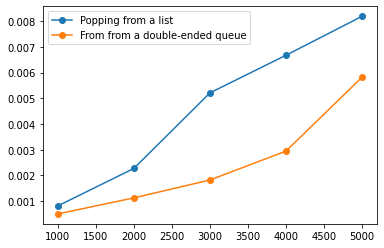

In [19]:
def test_pop_list(n):
    return test_callable(n, poping_from_list)

def test_pop_queue(n):
    return test_callable(n, poping_from_queue)

compare(("Popping from a list", test_pop_list),
         ("From from a double-ended queue", test_pop_queue),
        minsize=1000,
        iterations=5,
        repetition=3)

**[Question for the Canvas quiz]** Test with larger sizes (ie increase iterations). Which implementation is clearly faster?

#### Here is a short solution (aka example of using lambda functions in Python)

All the code written in the cells above can be reduced by using lambda functions in python (short one-liner functions lacking a proper name used in a functional programming style):

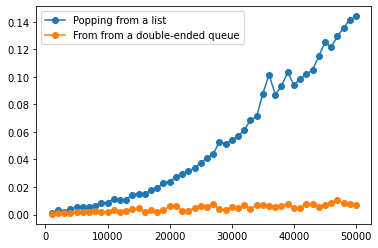

In [20]:
compare(("Popping from a list", 
             lambda n: lambda: pop_one_quarter_list(list(generator(n)))),
         ("From from a double-ended queue", 
              lambda n: lambda: pop_one_quarter_queue(deque(generator(n)))),
        minsize=1000,
        iterations=50,
        repetition=1)

## Example (b): Storing elements with a list (or matrix) or a dictionary (aka hashmap)?

Let's have another example playing with the data structure's complexity, slightly more involved this time. Let's consider the following very common scenario: you have multi-dimmensional data that you must organize and you are hesitating between using a matrix based on lists or a Python dictionary. Let's assume for example you have 2D datapoints $(x,y)$ such $1 \leq x, y \leq n$ and each is associated with a certain value. An operation that you will often have to do is for example to sum all the values and you are wondering which data structure is better to store the datapoints (it is assumed here that datapoints have also often to be modified so we don't want a structure dedicated to calculate the sum, such as simly the list of values).

Here is a typical example where the answer is not binary. Using a dictionary might seem the best option as only values stored are accessed, but consider that going through all values is more costly than looping through an equivalent size list.

Let's have a look how they perform on an example.

In [66]:
from math import sqrt

"""
    Here 'n' is the total range for the 2D-point as explained above.
    And 'i' is how many random items to add to the datastructure.
"""

def using_dict(n,i):
    n, i = int(sqrt(n)), int(sqrt(i))
    d = {}
    for a in range(i):
        for b in range(i):
            d[(a,b)] = random()    
    sum(d.values())
    
def using_lists(n,i):
    n, i = int(sqrt(n)), int(sqrt(i))
    L = [[0]*n for _ in range(n)]
    for a in range(i):
        for b in range(i):
            L[a][b] = random()    
    sum(x for row in L for x in row)

### Question 2

Compare both implementations by adding different number of items to the datastructure. Depending how fast your machine is, you can use eg iterations=12 here.

Which one is faster and from how much data?

# Part 2 -- Remember to stream your DATA

Python includes a well-designed mecanism to stream data called generators. Using generators allows to alleviate the use of allocating a structure to hold data if not needed; for example, almost all Python built-in functions (min/max, sum, iteration functions etc) use iterators by default avoiding in many situations the need of storing data.

Let's make a simple example to vizualize how this can make your code more efficient. Streaming takes its full adventage when alleviating the allocation of huge memory space. Here is an example where we check how to retrieve the argmin from a certain list, in one example where we allocate the list in memory and in the second where we use streaming directly on the generator producing data. On top of being faster, the streaming implementation avoided the allocation of about ~10GB of memory (with `minsize=50_000_000`).

In [15]:
"""
    Here are two implementations of the argmin function, that returns the minimum of the iterable L.
    
    The first function 'argmin' assumes L is a list, hence can be adressed via eg L[0] etc.
    
    The second function 'argmin_streaming' does not make this assumption and just iterates through the iterable.
"""

def argmin(L):
    argminL, minL = 0, L[0]
    for i in range(1, len(L)):
        if L[i] < minL:
            argminL, minL = i, L[i]
    return argminL

def argmin_streaming(L):
    argminL, minL = 0, next(L)
    for i, elem in enumerate(L):
        if elem < minL:
            argminL, minL = 1+i, elem
    return argminL

In particular, if one does not have 10 GB free of memory, only the streaming version can be considered. For example, on my laptop with about 12 GB of free memory, `argmin_streaming(generator(350_000_000))` does not pose any problem whereas `argmin(generator(350_000_000))` makes my computer fill up memory and swap up to the point of being killed by the OS, jupyter seeing the process as a still running cell.

The above example could also serve as a reminder for not reinventing the wheel, especially in Python! For example the function argmin is alrady provided by numpy! Let's compare different versions of the argmin function:

In [5]:
from math import sin, cos
import numpy as np

"""
    Here are 4 different implementations of the 'argmin' function.
"""

def argmin_lazy(L):
    return L.index(min(L))

def argmin(L):
    argminL, minL = 0, L[0]
    for i in range(1, len(L)):
        if L[i] < minL:
            argminL, minL = i, L[i]
    return argminL

def argmin_streaming(L):
    argminL, minL = 0, next(L)
    for i, elem in enumerate(L):
        if elem < minL:
            argminL, minL = 1+i, elem
    return argminL

def argmin_streaming2(L):
    return min((elem, i) for i, elem in enumerate(L))[1]

"""
    Example of input to test with.
"""

def example_generator(n):
    for x in lists[n]:
        yield sin(x)*cos(x)
        
def example_list(n):
    return list(example_generator(n))


### Question 3

Which implementation is faster?

*(Don't hesitate to go up to iterations=20 here!)*

#  Part 3 -- Remember to use multiprocessing for repetitive tasks

Python is an interpreted language where the interpreter has historically been a monocore process (at least till now but discussions are ongoing on removing in the future the infamous *GIL*, https://www.infoworld.com/article/3704248/python-moves-to-remove-the-gil-and-boost-concurrency.html). 

You will therefore not have anything like real “multithreading” in Python. However, Python has made lots of facilities for “multiprocessing” that is running several programs in parallel. This makes things that are easily parallelizable very fast to implement. 

Typical tasks that are very easy parallelizable include aggregate functions like min/max, sum/average etc and results from simulations. Let's have a further look at the latter, which is one of the main tasks where scripts come into play. 

For this example, we assume a fake function called `complicated_simulation(n)` that will serve as a dummy function for what we are interested in simulating (eg a program that we want to measure execution time, the output of a random algorithm etc). Our call is execution `nb_runs` and output the average of all simulations, and we will simulate our funciton for increasing values of `nb_runs`.

Let's compare a sequential implementation to a parallel one.

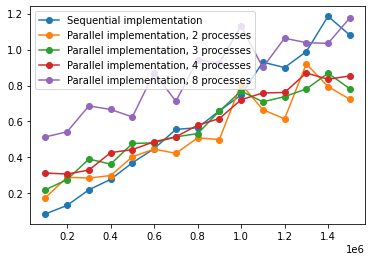

In [70]:
from math import sin, cos, sqrt
import multiprocessing as mp

"""
    Here are:
        -a dummy slow simulation function 'complicated_simulation'
        -a macro to calculate the average of 'nb_runs' of the complicated function
        -another macro to calculate the same but using 'nb_processes' different processes
"""

def complicated_simulation(n):
    return sqrt(n)*random()/(cos(random())*sin(random()))

def avg_simulations(nb_runs):
    return sum(complicated_simulation(nb_runs) for _ in range(nb_runs))/nb_runs

def avg_sim_parallel(nb_runs, nb_processes):
    with mp.Pool(processes=nb_processes) as pool:
        return sum(pool.map(avg_simulations, [nb_runs//nb_processes]*nb_processes, 1))/nb_processes
        
# running time with 1 (single process) to 4 processes (multiprocessing)

compare(("Sequential implementation", lambda n: lambda: avg_simulations(n)),
        ("Parallel implementation, 2 processes", lambda n: lambda: avg_sim_parallel(n, 2)),
        ("Parallel implementation, 3 processes", lambda n: lambda: avg_sim_parallel(n, 3)),
        ("Parallel implementation, 4 processes", lambda n: lambda: avg_sim_parallel(n, 4)),
        ("Parallel implementation, 8 processes", lambda n: lambda: avg_sim_parallel(n, 8)),
        iterations=15, repetition=2)


### Question 4

Check how many cores are available on your machine and compare the time needed by the above calculations when using different number of processes.

Is it always faster to use more processes?

### GIL's removal in latest Python!

In [Python's version 3.13](https://www.python.org/downloads/) (released **October 8th, 2024**), the GIL can be dsiabled at runtime by setting the environment variable `PYTHONGIL` to 0.

This has the direct effect of introducing *real* multithreading in Python. Some interesting articles with further explanations:
- https://www.lesinskis.com/python-GIL-removal.html
- https://medium.com/@mitesh.singh.jat/gil-becomes-optional-in-python-3-13-a-game-changer-for-multithreading-4c5d28856803
- https://medium.com/@r_bilan/python-3-13-without-the-gil-a-game-changer-for-concurrency-5e035500f0da

# Part 4 -- Remember the different types of memory

Always keep in mind that access to the file system is order of magnitude slower than access to main memory. This can sound obvious but tentation can be great to re-again some data from disk to not have to store it somewhere in memory, but this is in general a bad idea.

### Question 5

Write a small simple experiment to show the difference between:
- generating a random list of size n
- reading an already generated list from disk

Which one is faster in general? And on your machine? Is there a big difference for eg iterations=10?

# Part 5 -- Remember to load efficiently your DATA in memory

An important part of scripting consists in saving data on disk and loading data into memory. When developping a script, you might encouter the situation where for every run of the script you need to reload from disk a (huge) database. Waiting for the data to load removes precious seconds of a developper time. Here let's see how we can make the process faster.


## Serializing data in Python

We assume that you have some database to load in memory for the purpose of your script. For that purpose, we will use the fake databases that we have generated at the beginning. We will assume that you already have a parser function reading the data on disk and generating a Python object, that is more or less anything that can be stored in a variable in Python.

For next run of your script, instead of reading from the disk again the data that requires parsing, you can recreate in memory the Python object that resulted from the parsing. For that to work, we need to serialize the object in the first place then deserialize when we need it, and the Python library for such jobs is called `pickle`.

Let's make a simple example with the fake databases and let's compare the loading time with parsing from disk. 




In [8]:
import pickle

"""
    Some short utils to save / load files
"""

def savedump(myobj, filename):
    with open(filename,'wb') as f:
        pickle.dump(myobj, f)

def loaddump(filename):
    with open(filename,'rb') as f:
        return pickle.load(f)
    
"""
    The following loads the generated databases in memory
"""
    
my_db = {}

def load_database(n):
    my_db[n] = list(file2stream(f"data{n}.csv"))


### Question 6

Compare the time to execute `load_database(n)` (parsing the file from disk) with saving the file on disk with `savedump` and loading the binary into memory with `loaddump`.

So which implementation is faster and by how much?

## Numpy's arrays

It is now commonplace to use numpy's arrays instead of list, but sometimes it is really overkill and could actually be detrimental! Consider the following code snipplets that work similarly as the `load_database` function and loads a stored database fromn disk but modifies how it is stored in memory.

In [12]:
def load_database_numpy_v1(n):
    my_db[n] =  np.array(list(file2stream(f"data{n}.csv")))
    
def load_database_numpy_v2(n):
    data = list(zip(*[line for line in file2stream(f"data{n}.csv")]))
    my_db[n] =  {}
    my_db[n]["ID"] = data[0]
    my_db[n]["floats"] = np.array(data[1:], dtype=float)

### Extra Question ('6b')

Compare loading the database in memory and storing it within a numpy's array as `load_database_numpy_v1` or `load_database_numpy_v2`. Are those more efficient than the original loading method? 

## Deallocating objects in Python

**Remember to flush objects from memory when not needed!**

Imagine the following scenario: large objects that you don't need anymore are currently wasting some memory space. How to flush (deallocate) them?

For example, assume you have loaded all the databases we had previously generated (e.g. while running a comparison) or executing the following code:

In [9]:
for n in test_sizes():
    load_database(n)

The above uses more than 1GB in memory. To deallocate objects in Python you need to loose all references to them so that they are captured by the automatic garbage collector. If you didn't save more copies of `my_db`, an easy way will be to reassign the variable. You can monitor your main memory usage live (with tools like *htop*) and see the memory getting freed after losing the reference:

In [10]:
my_db = {}

*In Jupyter, you can also restart the Kernel to reset memory. You'll have of course to re-execute any required cell.*

## Finding an old dump

One downside of taking the habit of dumping large amount of data from possibly complicated Python objects is that the dump is completely dependent on how the object was constructed in the first place and it might be tricky without documentation to retrieve the version of the software that was used to generate a particular dump. For very large data taking considerable amount of time to generate, the old dump is not useless but using <a href="https://book.pythontips.com/en/latest/object_introspection.html">introspection</a>, we can explore the data structure and for example, convert it to a more appropriate format/object.

In [15]:
data = loaddump("data100000.dump")
dir(data)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

## And watch out when using copy and deepcopy of your objects

Copying object is often both needed and in the same time an important source of execution time. Let's make a simple example to explore the deepcopy mecanism built-in in Python's library.

In [9]:
from copy import copy, deepcopy

"""
    Here is a simple class object that stores a list of numbers (here generated at random on its creation)
"""

class MyObject:
    def __init__(self, n):
        self.mylist = [random() for _ in range(n)]

Remember the difference between a shallow copy (copy using references only) and a deep copy (all objects are copied in a recursive fashion). For example, consider the below code where the copy was only shallow:

In [10]:
x = MyObject(10)
print(x.mylist[0])
y = copy(x)
x.mylist[0] = 42
y.mylist[0]

0.904298995162786


42

And compare it to the same example with a deep copy:

In [11]:
x = MyObject(10)
print(x.mylist[0])
y = deepcopy(x)
x.mylist[0] = 42
y.mylist[0]

0.04291526354148956


0.04291526354148956

Let's compare the efficiency of the deepcopy function from the copy module with a naive ad hoc based copy:

In [12]:
"""
    Object inherited from parent object 'MyObject' with one additional method: 'copy_my_object'
"""

class MyObjectWithCopy(MyObject):
    def copy_my_object(self):
        a = MyObject(0)
        a.mylist = self.mylist[:] 
        return a

### Question 7

In this example, which implementation is faster?

# Part 6 -- Remember that DATA representation does always matter

We will compare here the time for *pickle-ing* a huge binary file and the time to parse a ASCII-formatted database.

In this example, we'll use our initial database. 

Converting to floats will keep roughly speaking the first 7 digits correct in the decimal extension whereas our database had 10 decimal precision; for many applications, such a conversion will have no impact. If more digits are needed, we can pack the Python floating point objects to "double" using 8 bytes instead of only 4; this way, we can keep up to 15 digits and encode *almost* exactly our data (*almost* because there will always be a small error due to the conversion).



In [3]:
import struct

"""
    Here are two methods to read / load a dataset in binary format
"""

def stream2binfile(data, filename):
    with open(filename, "wb") as outputfile:
        for record in data:
            outputfile.write(bytes.fromhex(record[0]))
            for i in range(3):
                outputfile.write(struct.pack("f", record[1+i]))
                
def binfile2stream(filename):
    with open(filename, "rb") as file:
        record = file.read(42)
        while record:
            yield record[:30].hex(), *[struct.unpack("f", record[30+i*4:30+(i+1)*4])[0] for i in range(3)]
            record = file.read(42)
            
"""
    We'll generate binary versions of our example database with the following.
"""

def generate_bin_databases(max_size_in_bytes=100_000_000, nb_files=10):
    for i in range(1,nb_files+1):
        n = i*max_size_in_bytes//(100*nb_files)
        stream2binfile(generate_database(n), f"data{n}.bin")
        
generate_bin_databases() 

Let's then compare the two strategies, first in terms of space: the second one using 42 bytes instead 100 per data point, generates of course a database 42% of the original size. If doubles were used, 54% uld be reached instead.
Now let's compare in terms of loading time, will we experience also only 42% loading time?

### Question 8

Which implementation is faster here to load data?

# Part 7 -- Final summary exercise

To test if you have learned some good tricks, write a short script to generate a small toy dataset and see if you can apply most of the tips mentioned in the tutorial.

### Final exercise

Imagine you need to generate some data for (stress-)testing some software you have recently starting using.

The data is made of objects of two types: *stores* and *clients*.

To generate a dataset of size **(N,M)**, place **N** stores and **M** clients on random poisitions over a map of size **L times L**.

Write a script that generate an easily loadable dataset that retrieves for each store, the list of clients within radius $\Delta = \sqrt{ \frac{L^2}{k * \pi} }$, where k is a parameter indicating that on average stores will be close to 1/k of all clients. 

Set L=100 and k=10 by deault.

Test your script by generating datasets of sizes from (10,100), (100,1000), ..., (10000,100000) and use a progress bar/counter to indicate progress during the generation (see part8/appendix if needed). 

*(It'd better be efficient! Is your implementation faster than the one autogenerated by e.g. ChatGPT or copilot?)*

# Part 8 -- Appendix: some more diverse Python tricks

*(part still under construction for now)*

Here is a list of diverse tips about Python programming.

### "Dynamic" printing in terminal output

Writing a "progress bar/counter" is much easier than people think... quite useful for slow processes. Also consider having intermediate/regular disk outputs so that results are not lost in case the script is interrupted.

In [11]:
from time import sleep

for i in range(101):
    print(i, "% of computational task has been completed.", end='\r')
    sleep(0.05)

### Accessing the history of the interactive interpreter

Whether you are using the jupyter notebook and a more traditional interactive interpreter such as idle, you can use the variable _ to access the last value displayed in (practical to avoid running a lengthy computation).

For example, execute the following:

In [32]:
from time import sleep

def some_function_that_was_lengthly_to_execute():
    sleep(10) # some very CPU intensive code here :)
    return [sin(x)*cos(x) for x in range(1000)]

some_function_that_was_lengthly_to_execute()

[0.0,
 0.4546487134128409,
 -0.37840124765396416,
 -0.13970774909946293,
 0.4946791233116909,
 -0.2720105554446849,
 -0.26828645900021747,
 0.4953036778474351,
 -0.14395165833253265,
 -0.375493623385838,
 0.4564726253638138,
 -0.004425654645201938,
 -0.4527891810033119,
 0.38127922523980134,
 0.13545289415393452,
 -0.4940158120464309,
 0.2757133406208453,
 0.2645413430600119,
 -0.49588942672155784,
 0.14818428935469266,
 0.37255658023967436,
 -0.4582607739578169,
 0.008850962552706789,
 0.45089417382440455,
 -0.3841273306618334,
 -0.13118742685196438,
 0.4933137960202426,
 -0.27939452442580814,
 -0.260775501043456,
 0.49643632404226856,
 -0.15240531055110834,
 -0.36959034832461146,
 0.46001301909839537,
 -0.013275577011983397,
 -0.44896384034464565,
 0.38694534077894455,
 0.12691168138101813,
 -0.49257313023412375,
 0.28305381844909017,
 0.2569892279937676,
 -0.49694432696168767,
 0.15661439121654258,
 0.36659516003664605,
 -0.4617292235020299,
 0.01769915136683034,
 0.446998331800279,

Oops, how will I get that table I generated without re-executing the cell?? Here you are:

In [33]:
table = _

table[:10]

[0.0,
 0.4546487134128409,
 -0.37840124765396416,
 -0.13970774909946293,
 0.4946791233116909,
 -0.2720105554446849,
 -0.26828645900021747,
 0.4953036778474351,
 -0.14395165833253265,
 -0.375493623385838]

*NB: In Ipython, you can as well access the second to last on with __ and third to last with ___.*

### The proper way to  uncompile a 2D list

There might be many ways to flatten multi-dimmensional data, but the one that is considered the most pythonic is:  
```[element for row in matrix for element in row]```

And that's it, the debate is close. Full stop :)

### Name your variables!

Imagine you have some labelled data called *summary* and for the sake of the example generate one such data with the following cell:

In [19]:
from random import random
summary_generator = lambda : (("field 0", random(), "field 2") for s in range(10))
summary = list(summary_generator())

Consider the following code that extract field number "1" from an iterable that was called "summary":

In [20]:
ids = set(trace[1] for trace in summary)
ids

{0.20195078080590367,
 0.22916947869377569,
 0.27788193620628054,
 0.4133138875425806,
 0.6795516290061746,
 0.7648940981763035,
 0.777492204056638,
 0.7931504651507256,
 0.9631931034020347,
 0.9870564777752268}

A better way would be to write the same code but in a much more readable manner:

In [22]:
ids = set(trace_id for trace_title, trace_id, *_ in summary)
ids

{0.20195078080590367,
 0.22916947869377569,
 0.27788193620628054,
 0.4133138875425806,
 0.6795516290061746,
 0.7648940981763035,
 0.777492204056638,
 0.7931504651507256,
 0.9631931034020347,
 0.9870564777752268}

### A useful design pattern for subclasses

Often we have to create dedicated classes using inheritance. Let's consider first a minimalist parent class example:

In [80]:
class ParentClass():
    def __init__(self):
        print("This is the constructor of the parent class")

def function_that_expects_a_parent(class_to_use):
    o = class_to_use()
    return o
    
function_that_expects_a_parent(ParentClass)

This is the constructor of the parent class


Imagine a sub-class that has simply an additional "instance_variable" set to a particular value.

One natural way to generate such a sub-class would be to write the following code:
    

In [75]:
class DedicatedChild(ParentClass):
    def __init__(self, value, *kargs, **kwargs):
        super().__init__(*kargs, **kwargs)
        self.instance_variable = value
        
print(DedicatedChild(10))

This is the constructor of the parent class


The problem with the above design is that now we have changed the constructor of the parent class which may result in not being able to re-use some previous code that instanciated the parent class in a particular manner. In particular, now one cannot simply call the 'function_that_expects_a_parent' with the 'DedicatedChild', ie:

In [77]:
function_that_expects_a_parent(DedicatedChild)

TypeError: __init__() missing 1 required positional argument: 'value'

Now consider the below code instead:

In [81]:
class ParentClass():
    # ... here usual constructor, methods etc
    def __init__(self):
        print("This is the constructor of the parent class")

    @classmethod
    def make(cls, value):
        class DedicatedChild(cls):
            def __init__(self, *kargs, **kwargs):
                super().__init__(*kargs, **kwargs)
                self.instance_variable = value
        return DedicatedChild 
    
# Now we can use a purpose-built class
o = function_that_expects_a_parent(ParentClass.make(10))
o.instance_variable

This is the constructor of the parent class


10

Here, we delegate the construction to a class method which will return a new class built on purpose. Then we can use this "DedicatedChild" in exactly the same way the "ParentClass" was used, just with the extra "instance_variable" set to the right value.

In summary, using such design patterns as the one above will not change in any way the "efficiency" of your scripts / Python code but will definitively make your scripts much shorter and easier to manage. Think about it!